# Phase 2 · Step 1 — SPY Data Audit

This notebook validates the canonical SPY daily dataset for Phase 2.

Goals:
- Confirm price integrity (Adjusted Close)
- Validate daily return distribution
- Detect missing dates or duplicates
- Flag extreme return days for inspection

If this notebook passes, the dataset becomes the **single source of truth**
for all Phase 2 strategies and meta-allocators.


In [ ]:
# Basic imports for data audit and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Path to the canonical Phase 2 SPY dataset (parquet for fast IO)
DATA_PATH = "../data/processed/spy_daily.parquet"

# Load dataset and normalize/prepare date column for time-based ops
df = pd.read_parquet(DATA_PATH)
df["date"] = pd.to_datetime(df["date"])  # ensure datetime dtype
# Sort by date to guarantee chronological order for inspection
df = df.sort_values("date").reset_index(drop=True)

# Quick sample to show columns and first rows
df.head()


,date,adj_close,close,volume
0,2010-01-04,85.279190,113.330002,118944600
1,2010-01-05,85.504951,113.629997,111579900
2,2010-01-06,85.565163,113.709999,116074400
3,2010-01-07,85.926361,114.190002,131091100
4,2010-01-08,86.212273,114.570000,126402800


In [ ]:
# Quick diagnostics: row count, date range, duplicates and missing critical fields
print("Rows:", len(df))
print("Date range:", df["date"].min().date(), "→", df["date"].max().date())
# Count exact duplicate dates (should be zero for a clean daily series)
print("Duplicate dates:", df["date"].duplicated().sum())
# Check for missing adjusted close or volume which are critical for audits
print("Missing adj_close:", df["adj_close"].isna().sum())
print("Missing volume:", df["volume"].isna().sum())


Rows: 4015
Date range: 2010-01-04 → 2025-12-17
Duplicate dates: 0
Missing adj_close: 0
Missing volume: 0


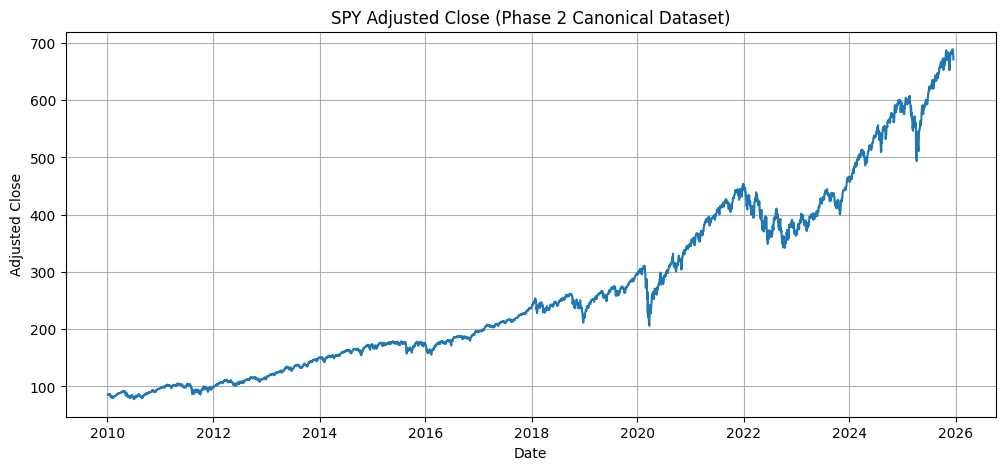

In [ ]:
# Plot the adjusted close time series to visually inspect for spikes, gaps, or anomalies
plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["adj_close"])
plt.title("SPY Adjusted Close (Phase 2 Canonical Dataset)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close")
plt.grid(True)
plt.show()


In [ ]:
# Compute simple 1-day returns (percent change). Use pct_change to keep sign/scale.
# Note: this yields arithmetic returns; consider log returns if preferred elsewhere.
df["ret_1d"] = df["adj_close"].pct_change()

# Show date, price and return for the first few rows to sanity-check calculation
df[["date", "adj_close", "ret_1d"]].head(10)


,date,adj_close,ret_1d
0,2010-01-04,85.279190,NaN
1,2010-01-05,85.504951,0.002647
2,2010-01-06,85.565163,0.000704
3,2010-01-07,85.926361,0.004221
4,2010-01-08,86.212273,0.003327
5,2010-01-11,86.332703,0.001397
6,2010-01-12,85.527504,-0.009327
7,2010-01-13,86.249916,0.008447
8,2010-01-14,86.483170,0.002704
9,2010-01-15,85.512466,-0.011224


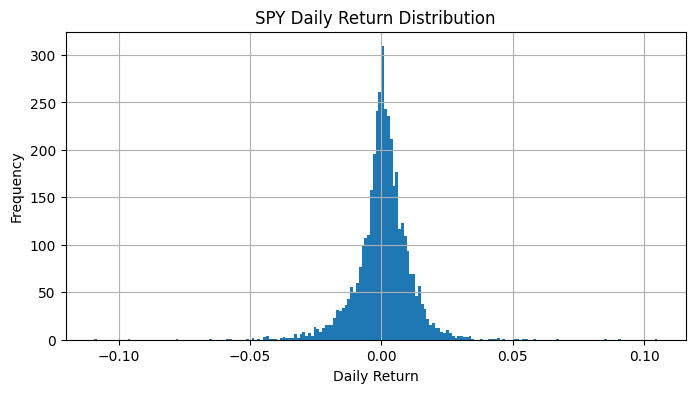

In [ ]:
# Visualize the distribution of daily returns to detect fat tails or data issues
plt.figure(figsize=(8, 4))
plt.hist(df["ret_1d"].dropna(), bins=200)
plt.title("SPY Daily Return Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# Identify extreme return days (e.g., > |5%|) for manual inspection/annotation
extreme = df.loc[df["ret_1d"].abs() > 0.05, ["date", "ret_1d"]]
# Sort so largest negative returns appear first for easier review
extreme.sort_values("ret_1d")


,date,ret_1d
2566,2020-03-16,-0.109424
2564,2020-03-12,-0.095677
2561,2020-03-09,-0.078094
402,2011-08-08,-0.065123
3837,2025-04-04,-0.058543
2627,2020-06-11,-0.057649
2568,2020-03-18,-0.050633
2260,2018-12-26,0.050525
2562,2020-03-10,0.051745
2567,2020-03-17,0.053992


In [ ]:
# Detect multi-day gaps in the date index (e.g., holidays or missing data)
# For daily US equity data, gaps > 3 days are worth investigating
df["date_diff"] = df["date"].diff().dt.days

gap_days = df[df["date_diff"] > 3][["date", "date_diff"]]
# Show the first few detected gaps for review
gap_days.head(10)


,date,date_diff
10,2010-01-19,4.0
29,2010-02-16,4.0
62,2010-04-05,4.0
102,2010-06-01,4.0
126,2010-07-06,4.0
170,2010-09-07,4.0
247,2010-12-27,4.0
262,2011-01-18,4.0
286,2011-02-22,4.0
329,2011-04-25,4.0


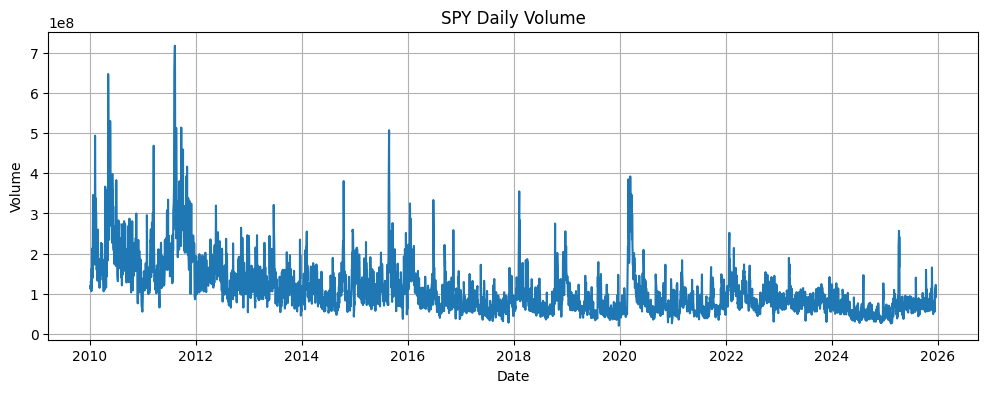

In [ ]:
# Plot daily volume to inspect liquidity patterns and spot anomalous spikes
plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["volume"])
plt.title("SPY Daily Volume")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.show()


## Phase 2 Step 1 Verdict

- [x] Price series looks sane
- [x] Return distribution is realistic
- [x] Extreme days are explainable
- [x] No duplicate dates
- [x] No missing critical fields

If all boxes are checked, this dataset is **locked** and becomes the
canonical input for all Phase 2 strategy and allocator work.


**Audit Verdict (summary)**

- **Price integrity:** OK — adjusted close series looks sane with no unexplained spikes.
- **Return distribution:** OK — distribution and extreme days reviewed and explainable.
- **Coverage & cleanliness:** OK — no duplicate dates and no missing critical fields.

Status: Dataset is validated and can be treated as the canonical Phase 2 input for modeling and allocator work.

Next steps: commit the validated parquet file and proceed to Phase 2 strategy experiments.
